## 手机客户流失预测

In [1]:
# 导入分析用到的模块
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib inline 可以在Ipython编译器里直接使用，功能是可以内嵌绘图，并且可以省略掉plt.show()这一步。 
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
# 导入csv文件
df = pd.read_excel('CustomerSurvival.xlsx',encoding='utf-8')
df.head()

,ID,套餐金额,额外通话时长,额外流量,改变行为,服务合约,关联购买,集团用户,使用月数,流失用户
0,1,1,792.833333,-10.450067,0,0,0,0,25,0
1,2,1,121.666667,-21.141117,0,0,0,0,25,0
2,3,1,-30.000000,-25.655273,0,0,0,0,2,1
3,4,1,241.500000,-288.341254,0,1,0,1,25,0
4,5,1,1629.666667,-23.655505,0,0,0,1,25,0


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4975 entries, 0 to 4974
Data columns (total 10 columns):
ID        4975 non-null int64
套餐金额      4975 non-null int64
额外通话时长    4975 non-null float64
额外流量      4975 non-null float64
改变行为      4975 non-null int64
服务合约      4975 non-null int64
关联购买      4975 non-null int64
集团用户      4975 non-null int64
使用月数      4975 non-null int64
流失用户      4975 non-null int64
dtypes: float64(2), int64(8)
memory usage: 388.8 KB


In [3]:
df.columns = ['id','pack_type','extra_time','extra_flow','pack_change',
             'contract','asso_pur','group_user','use_month','loss']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4975 entries, 0 to 4974
Data columns (total 10 columns):
id             4975 non-null int64
pack_type      4975 non-null int64
extra_time     4975 non-null float64
extra_flow     4975 non-null float64
pack_change    4975 non-null int64
contract       4975 non-null int64
asso_pur       4975 non-null int64
group_user     4975 non-null int64
use_month      4975 non-null int64
loss           4975 non-null int64
dtypes: float64(2), int64(8)
memory usage: 388.8 KB


id -- 用户的唯一标识<br>
pack_type -- 用户的月套餐的金额，1为96元以下，2为96到225元，3为225元以上<br>
extra_time -- 用户在使用期间的每月额外通话时长，这部分需要用户额外交费。数值是每月的额外通话时长的平均值,单位：分钟<br>
extra_flow -- 用户在使用期间的每月额外流量，这部分需要用户额外交费。数值是每月的额外流量的平均值，单位：兆<br>
pack_change -- 是否曾经改变过套餐金额，1=是，0=否<br>
contract -- 用户是否与联通签订过服务合约，1=是，0=否<br>
asso_pur -- 用户在使用联通移动服务过程中是否还同时办理其他业务，1=同时办理一项其他业务，2=同时办理两项其他业务，0=没有办理其他业务<br>
group_use -- 用户办理的是否是集团业务，相比个人业务，集体办理的号码在集团内拨打有一定优惠。1=是，0=否<br>
use_month -- 截止到观测期结束（2012.1-2014.1），用户使用联通服务的时间长短，单位：月<br>
loss -- 在25个月的观测期内，用户是否已经流失。1=是，0=否<br>

### 【数据的探索性分析】

In [4]:
df.describe()

,id,pack_type,extra_time,extra_flow,pack_change,contract,asso_pur,group_user,use_month,loss
count,4975.000000,4975.000000,4975.000000,4975.000000,4975.000000,4975.000000,4975.000000,4975.000000,4975.000000,4975.000000
mean,2488.000000,1.057688,258.520030,-71.580403,0.021307,0.245226,0.047437,0.227337,14.774271,0.782714
std,1436.303125,0.258527,723.057190,275.557448,0.144419,0.430264,0.278143,0.419154,6.534273,0.412441
min,1.000000,1.000000,-2828.333333,-2189.875986,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,1244.500000,1.000000,-126.666667,-74.289824,0.000000,0.000000,0.000000,0.000000,13.000000,1.000000
50%,2488.000000,1.000000,13.500000,-59.652734,0.000000,0.000000,0.000000,0.000000,13.000000,1.000000
75%,3731.500000,1.000000,338.658333,-25.795045,0.000000,0.000000,0.000000,0.000000,19.000000,1.000000
max,4975.000000,3.000000,4314.000000,2568.704293,1.000000,1.000000,2.000000,1.000000,25.000000,1.000000


可以看到extra_time和extra_flow有正负值，正数表示用户有额外的通话时长和流量，负数为用户在月底时剩余的套餐时长和流量。从四分位数中可看出超过一半的用户有额外通话时间，流量的话只有小部分用户超额使用了。另外其他的分类型变量在描述统计上并未发现有异常的地方。<br>
<br>
在这里特别注意下use_month这个变量，数据的观测区间为2012.1-2014.1，一共25个月，且案例中关于流失的定义为：
<br>
超过一个月没有使用行为（包括通话，使用流量）的用户判定为流失。
<br>
在数据集中use_month小于25个月的基本都是流失状态，所以这个变量对于流失的预测并没有什么关键作用，后续导入模型时需剔除这个变量。

### 2. 变量的分布

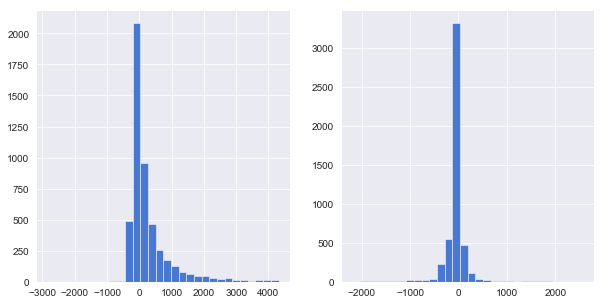

In [5]:
# 首先看一下两个连续型变量：extra_time和extra_flow的数据分布：
plt.figure(figsize = (10,5))
plt.subplot(121)
df.extra_time.hist(bins = 30)
plt.subplot(122)
df.extra_flow.hist(bins = 30)

extra_time呈现的是右偏分布，extra_flow近似服从正态分布，与描述统计中的情况大致吻合

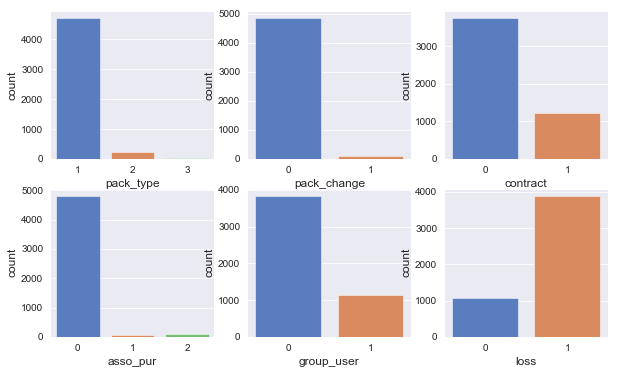

In [6]:
# 接下来看看分类型变量的分布：
# 以bar的形式展示每个类别的数量
# 金额  是否曾经改变过套餐金额    用户是否与联通签订过服务合约  
# 用户在使用联通移动服务过程中是否还同时办理其他业务   用户办理的是否是集团业务   流失
fig,axes = plt.subplots(nrows = 2,ncols = 3, figsize = (10,6))
sns.countplot(x = 'pack_type',data = df,ax=axes[0,0])
sns.countplot(x = 'pack_change',data = df,ax=axes[0,1])
sns.countplot(x = 'contract',data = df,ax=axes[0,2])
sns.countplot(x = 'asso_pur',data = df,ax=axes[1,0])
sns.countplot(x = 'group_user',data = df,ax=axes[1,1])
sns.countplot(x = 'loss',data = df,ax=axes[1,2])

可以看到pack_type, pack_change, asso_pur的类型分布非常不均衡，例如asso_pur,办理过套餐外业务的用户数量极少，导致样本缺乏足够的代表性，可能会对模型的最终结果产生一定的影响。

### 3. 自变量与因变量之间的关系：

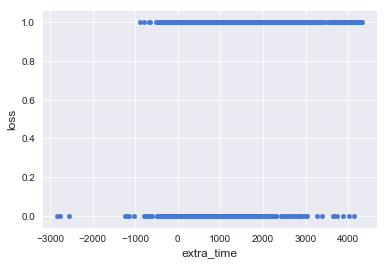

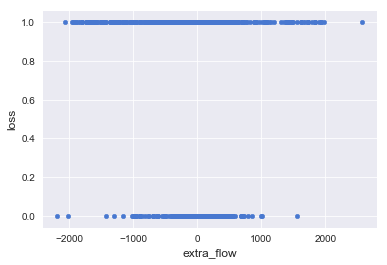

In [7]:
# 对于extra_time和extra_flow绘制散点图观察：
plt.figure(figsize = (10,6))
df.plot.scatter(x='extra_time',y='loss')
df.plot.scatter(x='extra_flow',y='loss')

从散点图上似乎感觉两个自变量与是否流失并无关系，为了更好的展示其相关性，我们对extra_time和extra_flow进行分箱处理，再绘制条形图：

In [8]:
# 增加分箱后的两个字段
# 将连续性数据离散化
bin1 = [-3000,-2000,-500,0,500,2000,3000,5000]
df['time_label'] = pd.cut(df.extra_time,bins = bin1)
# 观察一下分箱后的数据分布
time_amount = df.groupby('time_label').id.count().sort_values().reset_index()
time_amount
time_amount['amount_cumsum'] = time_amount.id.cumsum()
time_amount


,time_label,id,amount_cumsum
0,"(-3000, -2000]",3,3
1,"(-2000, -500]",15,18
2,"(3000, 5000]",79,97
3,"(2000, 3000]",129,226
4,"(500, 2000]",755,981
5,"(0, 500]",1634,2615
6,"(-500, 0]",2360,4975


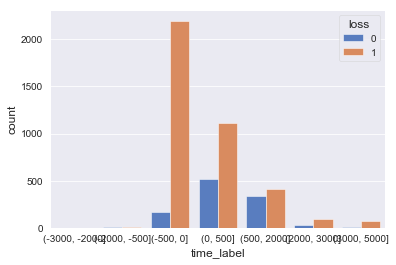

In [9]:
sns.countplot(x = 'time_label',hue = 'loss',data =df)
# ---对extra_time进行累加统计，发现【-500,500】这个区间的用户占了80%，符合二八定律
# hue可以返回每一个区间的loss

In [10]:
bin2 = [-3000,-2000,-500,0,500,2000,3000]
df['flow_label'] = pd.cut(df.extra_flow,bins = bin2)
flow_amount = df.groupby('flow_label').id.count().sort_values().reset_index()
flow_amount['amount_cumsum'] = flow_amount.id.cumsum()
flow_amount

,flow_label,id,amount_cumsum
0,"(2000, 3000]",1,1
1,"(-3000, -2000]",3,4
2,"(500, 2000]",79,83
3,"(-2000, -500]",157,240
4,"(0, 500]",827,1067
5,"(-500, 0]",3908,4975


---对extra_flow进行累加统计，发现【-500,500】占了95%，且（-500,0】的用户占80%，可以说只有小部分用户每月会超额使用流量。

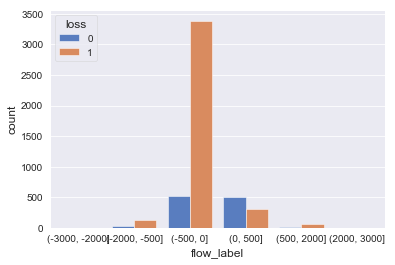

In [11]:
sns.countplot(x = 'flow_label',hue = 'loss',data =df)
# 使用bars来表示每个分类数据的数目

可以明显的看出用户使用的通话时间和流量越多，流失概率越低，这些超额使用的用户在用户分类中属于'高价值用户'，用户粘性很高，运营商应该把重点放在这些用户身上，采取有效的手段预防其流失。

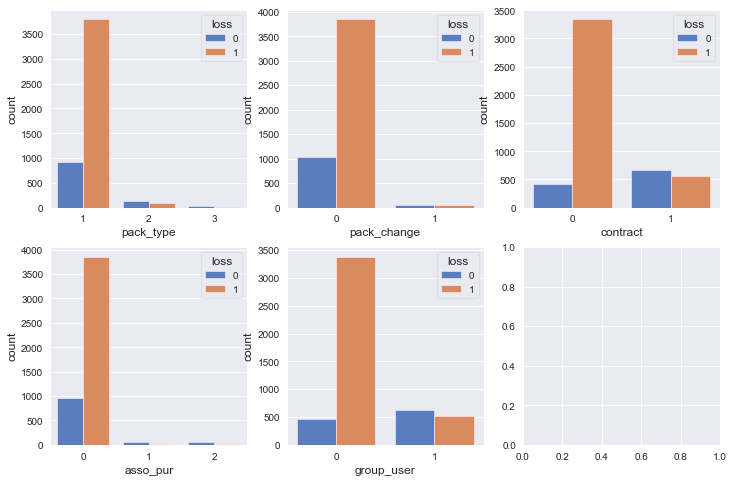

In [12]:
fig,axes = plt.subplots(nrows = 2,ncols = 3, figsize = (12,8))
sns.countplot(x = 'pack_type',hue = 'loss',data =df,ax = axes[0][0])
sns.countplot(x = 'pack_change',hue = 'loss',data =df,ax = axes[0][1])
sns.countplot(x = 'contract',hue = 'loss',data =df,ax = axes[0][2])
sns.countplot(x = 'asso_pur',hue = 'loss',data =df,ax = axes[1][0])
sns.countplot(x = 'group_user',hue = 'loss',data =df,ax = axes[1][1])

初步得出以下结论：<br>
1）.套餐金额越大，用户越不易流失，套餐金额大的用户忠诚度也高<br>
2）.改过套餐的用户流失的概率变小<br>
3）.签订过合约的流失比例较小，签订合约也意味着一段时间内（比如2年，3年）用户一般都不会更换运营商号码，可以说签订合约的用户比较稳定<br>
4）.办理过其它套餐业务的用户因样本量太少，后续再研究<br>
5）.集团用户的流失率相比个人用户低很多<br>

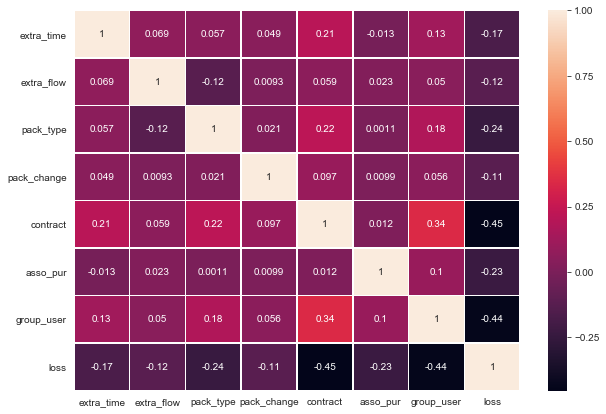

In [13]:
internal_chars = ['extra_time','extra_flow','pack_type',
                 'pack_change','contract','asso_pur','group_user','loss']
corrmat = df[internal_chars].corr()
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='0')
sns.heatmap(corrmat, square=False, linewidths=.5, annot=True)

各自变量之间的相关性程度很低，排除了共线性问题。在对因变量的相关性上contract和group_user的系数相比其它变量较高，但也不是很强。

### 数据建模

因为自变量大多数为分类型，所以用决策树的效果比较好，而且决策树对异常值的敏感度很低，生成的结果也有很好的解释性。


---因变量是 'loss'，是否流失，也是我们预测的目标值<br>
---自变量分为三类：<br>
#连续型变量：extra_time，extra_flow,  use_month<br>
#二元分类变量：pack_change，contract,  group_use<br>
#多元分类变量：pack_type，asso_pur<br>

根据前面的探索性分析，并基于业务理解，我们决定筛选这几个特征进入模型：<br>
extra_time，extra_flow，pack_type,  pack_change,  asso_pur<br>
contract以及group_use，这些特征都对是否流失有一定的影响。<br>
对于extra_time，extra_flow这两个连续型变量我们作数据转换，变成二分类变量，这样所有特征都是统一的度量。<br>

In [11]:
df['time_tranf'] = df.apply(lambda x:1 if x.extra_time>0 else 0,axis =1)
df['flow_tranf'] = df.apply(lambda x:1 if x.extra_flow>0 else 0,axis =1)
df.head()
# 将没有超出套餐的通话时间和流量记为0，超出的记为1。

,id,pack_type,extra_time,extra_flow,pack_change,contract,asso_pur,group_user,use_month,loss,time_label,flow_label,time_tranf,flow_tranf
0,1,1,792.833333,-10.450067,0,0,0,0,25,0,"(500, 2000]","(-500, 0]",1,0
1,2,1,121.666667,-21.141117,0,0,0,0,25,0,"(0, 500]","(-500, 0]",1,0
2,3,1,-30.000000,-25.655273,0,0,0,0,2,1,"(-500, 0]","(-500, 0]",0,0
3,4,1,241.500000,-288.341254,0,1,0,1,25,0,"(0, 500]","(-500, 0]",1,0
4,5,1,1629.666667,-23.655505,0,0,0,1,25,0,"(500, 2000]","(-500, 0]",1,0


In [15]:
x = df.loc[:,['pack_type','time_tranf','flow_tranf','pack_change','contract','asso_pur','group_user']]
x = np.array(x)
x

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 0, 0],
       [3, 0, 0, ..., 1, 0, 1]], dtype=int64)

In [16]:
y = df.loss
y = y[:, np.newaxis]
y

array([[0],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]], dtype=int64)

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3,random_state=123)

In [33]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='entropy', #--设置衡量的系数
                                    splitter='best', #--选择分类的策略
                                    max_depth=4, #--设置树的最大深度
                                    min_samples_split=10,#--节点的最少样本数
                                    min_samples_leaf=5 #-- 叶节点的最少样本数
                                    )
clf = clf.fit(x_train,y_train) # -- 拟合训练

这里我们采用决策树中ID3算法，基于entropy系数进行分类，设置树的最大深度为4，区分一个内部节点需要的最少的样本数为10，一个叶节点所需要的最小样本数为5。

In [40]:
train_score = clf.score(x_train,y_train) # 训练集的评分
test_score = clf.score(x_test,y_test)   # 测试集的评分
'train_score:{0},test_score:{1}'.format(train_score,test_score)

'train_score:0.871338311315336,test_score:0.8640321500334897'

### 参数调优

In [35]:
# 模型的参数调优--max_depth
# 创建一个函数，使用不同的深度来训练模型，并计算评分数据
def cv_score(d):
    clf2 = tree.DecisionTreeClassifier(max_depth=d)
    clf2 = clf2.fit(x_train,y_train)
    tr_score = clf2.score(x_train,y_train)
    cv_score = clf2.score(x_test,y_test)
    return (tr_score, cv_score)
# 构造参数范围，在这个范围内构造模型并计算评分
depths = range(2,15)
scores = [cv_score(d) for d in depths]
tr_scores = [s[0] for s in scores]
cv_scores = [s[1] for s in scores]
scores
# 找出交叉验证数据集最高评分的那个索引
best_score_index = np.argmax(cv_scores)
best_score = cv_scores[best_score_index]
best_param = depths[best_score_index]
best_param
# best_score

4

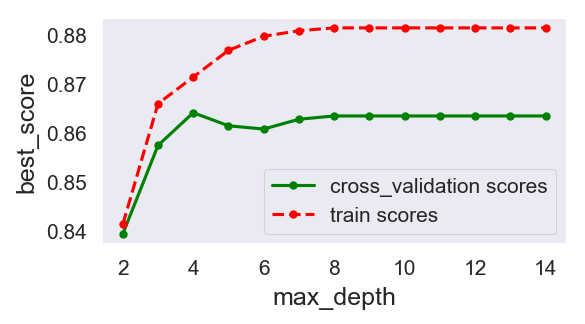

In [36]:
plt.figure(figsize = (4,2),dpi=150)
plt.grid()
plt.xlabel('max_depth')
plt.ylabel('best_score')
plt.plot(depths, cv_scores,'.g-',label = 'cross_validation scores')
plt.plot(depths,tr_scores,'.r--',label = 'train scores')
plt.legend()

在生成的图中可以看出当深度为4时，交叉验证数据集的评分与训练集的评分比较接近，且两者的评分比较高，当深度超过5以后，俩者的差距变大，交叉验证数据集的评分变低，出现了过拟合情况。

### 模型结果评价

In [37]:
from sklearn.metrics import classification_report
y_pre = clf.predict(x_test)
print(classification_report(y_pre,y_test))

             precision    recall  f1-score   support

          0       0.65      0.71      0.68       304
          1       0.92      0.90      0.91      1189

avg / total       0.87      0.86      0.87      1493



精确率 = TP/(TP+FP)  ：在预测为流失的用户中，预测正确的（实际也是流失）用户占比<br>
召回率 = TP/(TP+FN)   : 在实际为流失的用户中，预测正确的（预测为流失的）用户占比<br>
F1值为精确率和召回率的调和均值，相当于这两个的综合评价指标。<br>
通过输出的分析报告可以得出建立的预测模型的精确率为0.88，说明在预测为流失的用户中，实际流失的用户占88%，召回率为0.86，说明实际为流失的用户中，预测为流失的占86%，F1值为0.87，说明模型的综合评价还不错。<br>

In [38]:
# import os
# os.environ["PATH"] += os.pathsep + 'D:\新建文件夹\graphviz-2.38\release\bin'  #注意修改你的路径

In [39]:
# import os
#  os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from IPython.display import Image  
from sklearn import tree
import pydotplus 
from sklearn.tree import export_graphviz
def TreeShow(dtClass,irisDataSet):
    dot_data = export_graphviz(dtClass, out_file=None)
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_pdf("tree.pdf")
    dot_data = export_graphviz(dtClass, out_file=None,
                               feature_names=['pack_type','time_tranf','flow_tranf'
                               ,'pack_change','contract','asso_pur','group_user'],   #对应特征的名字
                              class_names=['loss','not loss'],    #对应类别的名字
                               filled=True, rounded=True,
                               special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    Image(graph.create_png())
TreeShow(clf,df)